In [1]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [2]:
data_path = '../data/train'

transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1), # 흑백으로 변환
        transforms.Resize([244, 244]),
        transforms.ToTensor()
    ]
)

train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    # 배치 사이즈 조절
    batch_size=32,
    shuffle=True
)

print(len(train_dataset))

2211


In [3]:
model = models.resnet18(pretrained=True)

# 첫 번째 합성곱 계층을 1채널 입력을 받도록 수정
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# 합성곱층 가중치 고정
for param in model.parameters():
    param.requires_grad = False

# 완전연결층 추가
model.fc = torch.nn.Linear(512, 2)

# 완전연결층 학습
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost      = torch.nn.CrossEntropyLoss()   # 손실함수 정의

C:\Users\geum_bi\anaconda3\envs\geum_bi\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\geum_bi\anaconda3\envs\geum_bi\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=10):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('../data', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history, loss_history

In [5]:
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(model, train_loader, criterion, optimizer, device)

Epoch 0/9
----------
Loss: 0.3883 Acc: 0.8634

Epoch 1/9
----------
Loss: 0.1790 Acc: 0.9611

Epoch 2/9
----------
Loss: 0.1354 Acc: 0.9706

Epoch 3/9
----------
Loss: 0.0976 Acc: 0.9801

Epoch 4/9
----------
Loss: 0.0876 Acc: 0.9806

Epoch 5/9
----------
Loss: 0.1042 Acc: 0.9670

Epoch 6/9
----------
Loss: 0.0729 Acc: 0.9828

Epoch 7/9
----------
Loss: 0.0671 Acc: 0.9842

Epoch 8/9
----------
Loss: 0.0567 Acc: 0.9914

Epoch 9/9
----------
Loss: 0.0573 Acc: 0.9869

Training complete in 18m 28s
Best Acc: 0.991407


In [7]:
test_path = '../data/val'

transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1), # 흑백으로 변환
        transforms.Resize([244, 244]),
        transforms.ToTensor()
    ]
)

test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    # 배치 사이즈 조절
    batch_size=32,
    shuffle=True
)

print(len(test_dataset))

949


In [8]:
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('../data/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history

In [9]:
val_acc_hist = eval_model(model, test_loader, device)

saved_model ['../data\\00.pth', '../data\\01.pth', '../data\\02.pth', '../data\\03.pth', '../data\\04.pth', '../data\\05.pth', '../data\\06.pth', '../data\\07.pth', '../data\\08.pth', '../data\\09.pth']
Loading model ../data\00.pth
Acc: 0.9336

Loading model ../data\01.pth
Acc: 0.9694

Loading model ../data\02.pth
Acc: 0.9737

Loading model ../data\03.pth
Acc: 0.9884

Loading model ../data\04.pth
Acc: 0.9884

Loading model ../data\05.pth
Acc: 0.9905

Loading model ../data\06.pth
Acc: 0.9916

Loading model ../data\07.pth
Acc: 0.9916

Loading model ../data\08.pth
Acc: 0.9926

Loading model ../data\09.pth
Acc: 0.9926

Validation complete in 7m 18s
Best Acc: 0.992624


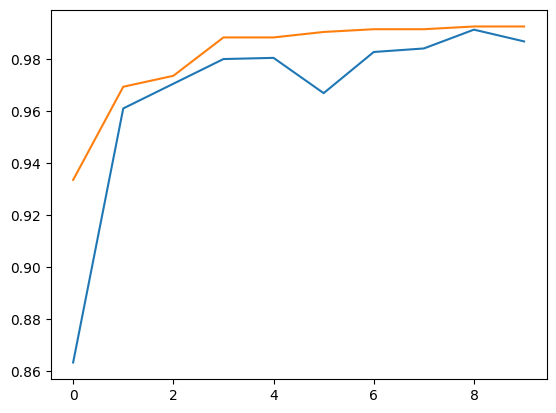

In [10]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

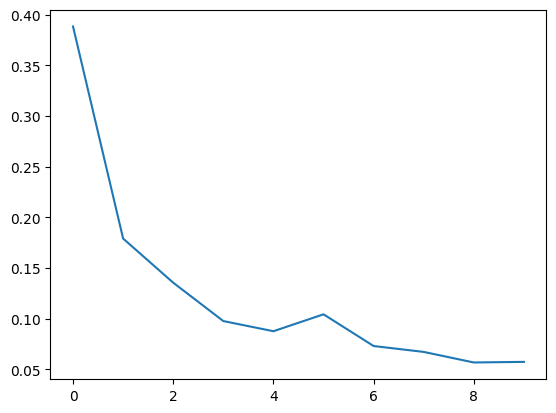

In [11]:
plt.plot(train_loss_hist)
plt.show()